# ML Project - Hate Speech Recognition - Oskar Bujacz, Piotr Słowik

In [ ]:
import tweepy
import csv
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/ml_project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ml_project


## data download from twitter

In [ ]:
# Twitter Developer keys here
consumer_key = 'SECRET'
consumer_key_secret = 'SECRET'
access_token = 'SECRET'
access_token_secret = 'SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
corpus = []
with open('/content/drive/My Drive/hate_ids.csv', 'r', encoding = 'utf8') as csvfile:
  lineReader = csv.reader(csvfile, delimiter=',', quotechar="\"")
  for row in lineReader:
    corpus.append({"tweet_id": row[0], "label": row[1]})
print(corpus[:10])

[{'tweet_id': '849667487180259329', 'label': 'abusive'}, {'tweet_id': '850490912954351616', 'label': 'abusive'}, {'tweet_id': '848791766853668864', 'label': 'abusive'}, {'tweet_id': '848306464892604416', 'label': 'abusive'}, {'tweet_id': '850010509969465344', 'label': 'normal'}, {'tweet_id': '850433664890544128', 'label': 'hateful'}, {'tweet_id': '847529600108421121', 'label': 'abusive'}, {'tweet_id': '848619867506913282', 'label': 'abusive'}, {'tweet_id': '850411934205845504', 'label': 'abusive'}, {'tweet_id': '848325397985071104', 'label': 'abusive'}]


In [ ]:
def createTrainingSet_infinite(corpus):
    train_temp = []
    sleepTime = 1

    for i, tweet in enumerate(corpus):
      if i<16200: continue
      if i % 100==0: print(i)
      if i==16906:
      #if i % 900 == 0 and i>-1:
        with open('/content/drive/My Drive/hate_text2.csv', 'a', encoding = 'utf8') as csvfile:
        #with open('/content/drive/My Drive/hate_text.csv', 'a', encoding = 'utf8') as csvfile:
          linewriter = csv.writer(csvfile, delimiter=',', quotechar="\"")
          for tweet in train_temp:
            try:
              linewriter.writerow([tweet["tweet_id"], tweet["text"], tweet["label"]])
            except Exception as e:
              continue

        print(len(train_temp))
        train_temp = []
        time.sleep(15*60)
      try:
            tweetFetched = api.get_status(tweet["tweet_id"])
            tweet["text"] = tweetFetched.text
            train_temp.append(tweet)
            time.sleep(sleepTime)

      except:
            continue

createTrainingSet_infinite(corpus)

### Raw data

In [ ]:
def printSome(first, last):
  for i in range(first,last):
    if i>= len(trainingDataSet): break
    print(trainingDataSet[i])
printSome(100,200)

{'tweet_id': '848028080576888832', 'label': 'abusive', 'text': 'RT @Boobie24Dixon: Hail Fucking State!!! https://t.co/Lkm1jQd2uF'}
{'tweet_id': '848524862305861632', 'label': 'abusive', 'text': 'Its not tht i hate the place even tho i dont like it but i hate the ppl who havent done anything to the bullshit tht happened.'}
{'tweet_id': '847842755221090309', 'label': 'abusive', 'text': 'RT @DickMorrisTweet: Schumer Filibuster Of Gorsuch Is Idiotic - Lunch Alert! https://t.co/kvnzCSK5tX @SenSchumer @TheDemocrats @HouseDemocr…'}
{'tweet_id': '850402564143230979', 'label': 'abusive', 'text': 'Nasty ass eating food @_JWEAVE_ @Mcj_da_great https://t.co/EqsAzUrRbh'}
{'tweet_id': '849167274485334016', 'label': 'abusive', 'text': "These fucking butn scars on my chest is so ugly! I can't even wear a shirt without having it zipped all the way up or a scarf on."}
{'tweet_id': '847661490001727489', 'label': 'abusive', 'text': "RT @Shae_Amoure: Mf's be having me fucked up ALLL the time !🤦🏽\u200d♀️"}


##  Preprocessing

In [ ]:
from collections import defaultdict 
import re
import csv
import numpy as np
from string import ascii_lowercase
import string
import random
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer


In [ ]:
#removing hyperlinks, hashtags and emojis (not ascii letters)
def check_correctness(word):

  if word[0] == '@' or word == "rt" or (len(word) > 4 and word[:4] == 'http'):
    return None
  if word[0] == '#':
    return None
  for letter in word:
    if letter not in ascii_lowercase:
      return None 
  return word

def get_dicts(corpus_whole, corpus_hate, corpus_normal,test_sents, filename, train_size=1, stemming=False):
  choices = ["abusive", "hateful", "normal", "spam"]
  if stemming !=False:
    if stemming == 'porter':
      chosen_stemming = PorterStemmer()
    if stemming == 'snowball':
      chosen_stemming = SnowballStemmer("english")
    if stemming == 'lancaster':
      chosen_stemming = LancasterStemmer()

  with open(filename,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    k=0
    normal_num = 0
    hate_num = 0
    abusive_num = 0
    spam_num = 0
    for row in reader:
      words = row[1].split()
      label = row[2]
      if label == 'hateful':
        hate_num+=1
      if label == 'abusive':
        abusive_num+=1
      if label == 'spam':
        spam_num+=1
      if label == 'normal':
        normal_num+=1

      if random.random() > train_size:
        test_sents.append((words,label))
      else:
        for word in words:
          w = check_correctness(word.lower())
          if w != None:
            w = w.translate(str.maketrans('', '', string.punctuation))

            if stemming != False:
              w = chosen_stemming.stem(w)
            if w not in corpus_whole:
              corpus_whole[w] = 1
            else:
              corpus_whole[w] = corpus_whole[w] + 1

            if label == 'normal':
              if w not in corpus_normal:
                corpus_normal[w] = 1
              else:
                corpus_normal[w] = corpus_normal[w] + 1            
            if label == 'abusive' or label == 'hateful':
              if w not in corpus_hate:
                corpus_hate[w] = 1
              else:
                corpus_hate[w] = corpus_hate[w] + 1
      k+=1
  print('normal {} hate {} abusive {} spam {}'.format(normal_num, hate_num, abusive_num, spam_num))
  return [corpus_whole, corpus_hate, corpus_normal], test_sents

## Corpus Creation For Naive Bayes

In [ ]:
corpuses = [{}, {}, {}]
test_sent = []
corpuses, test_sent = get_dicts(corpuses[0], corpuses[1], corpuses[2], test_sent, "hate_text.csv", 0.8)
corpuses, test_sent = get_dicts(corpuses[0], corpuses[1], corpuses[2], test_sent, "converted_gab.csv", 0.8)
corpuses, test_sent = get_dicts(corpuses[0], corpuses[1], corpuses[2], test_sent, "converted_reddit.csv", 0.8)

print('no stemming')
print('normal', len(corpuses[2]), 'hate', len(corpuses[1]), 'whole', len(corpuses[0]))

normal 35170 hate 1770 abusive 4195 spam 7885
normal 17396 hate 14614 abusive 0 spam 0
normal 11732 hate 5257 abusive 0 spam 0
no stemming
normal 39376 hate 23690 whole 49150


In [ ]:
corpuses_s2 = [{}, {}, {}] #stemming snowball
test_sent_s2 = []
corpuses_s2, test_sent_s2 = get_dicts(corpuses_s2[0], corpuses_s2[1], corpuses_s2[2], test_sent_s2, "hate_text.csv", 0.8, stemming='snowball')
corpuses_s2, test_sent_s2 = get_dicts(corpuses_s2[0], corpuses_s2[1], corpuses_s2[2], test_sent_s2, "converted_gab.csv", 0.8,stemming='snowball')
corpuses_s2, test_sent_s2 = get_dicts(corpuses_s2[0], corpuses_s2[1], corpuses_s2[2], test_sent_s2, "converted_reddit.csv", 0.8,stemming='snowball')
print('snowball stemming')
print('normal', len(corpuses_s2[2]), 'hate', len(corpuses_s2[1]), 'whole', len(corpuses_s2[0]))

normal 35170 hate 1770 abusive 4195 spam 7885
normal 17396 hate 14614 abusive 0 spam 0
normal 11732 hate 5257 abusive 0 spam 0
snowball stemming
normal 27807 hate 16041 whole 34762


In [ ]:
corpuses_stem1 = [{}, {}, {}] #lancaster stemmer
test_sent_stem1 = []
corpuses_stem1, test_sent_stem1 = get_dicts(corpuses_stem1[0], corpuses_stem1[1], corpuses_stem1[2], test_sent_stem1, "hate_text.csv", 0.8, stemming='lancaster')
corpuses_stem1, test_sent_stem1 = get_dicts(corpuses_stem1[0], corpuses_stem1[1], corpuses_stem1[2], test_sent_stem1, "converted_gab.csv", 0.8, stemming='lancaster')
corpuses_stem1, test_sent_stem1 = get_dicts(corpuses_stem1[0], corpuses_stem1[1], corpuses_stem1[2], test_sent_stem1, "converted_reddit.csv", 0.8, stemming='lancaster')

print('lancaster stemming')
print('normal', len(corpuses_stem1[2]), 'hate', len(corpuses_stem1[1]), 'whole', len(corpuses_stem1[0]))

normal 35170 hate 1770 abusive 4195 spam 7885
normal 17396 hate 14614 abusive 0 spam 0
normal 11732 hate 5257 abusive 0 spam 0
lancaster stemming
normal 23344 hate 13773 whole 29420


## Naive Bayes


In [ ]:
def naive_bayes_clf(sent, corpus_normal, corpus_hate, stemming=False):
  words_sent = []
  for word in sent:
    w = check_correctness(word.lower())
    if w != None:
      w = w.translate(str.maketrans('', '', string.punctuation))

      if w in hate_word: #important for accuracy
        return 0

      words_sent.append(w)
  p_normal = np.log(1/len(corpus_normal))
  p_hate = np.log(1/len(corpus_hate))
  snowBallStemmer = SnowballStemmer("english")
  predict = 0 #normal 0, hate 1
  if stemming:
    if stemming == 'snowball':
      words_sent = [snowBallStemmer.stem(word) for word in words_sent]
    if stemming == 'lancaster':
      snowBallStemmer = LancasterStemmer()
      words_sent = [snowBallStemmer.stem(word) for word in words_sent]

  for word in words_sent:
    if (word not in corpus_normal) and (word in corpus_hate):
      if corpus_hate[word] >=3: return 0

    if word in corpus_normal:
      p_normal += np.log(corpus_normal[word])
    else:
      p_normal += np.log(1/len(corpus_normal))
    if word in corpus_hate:
      p_hate += np.log(corpus_hate[word])
    else:
      p_hate += np.log(1/len(corpus_hate))

  if p_normal >= p_hate:
    return 1
  else: 
    return 0

In [ ]:
def test_naive_bayes_clf(sents, corpus_normal, corpus_hate, stemming=False):

  total_num = 0
  correct_pred = 0
  normal_num = 0
  normal_corr = 0
  hate_num = 0
  hate_corr = 0
  for sent in sents:
    if sent[1] == 'spam': continue
    pred = naive_bayes_clf(sent[0], corpus_normal, corpus_hate,stemming)
    if sent[1] == 'normal':

      normal_num +=1
    else:
      hate_num +=1

    if sent[1] == 'normal' and pred == 1:
      correct_pred+=1
      normal_corr+=1
    if sent[1] != 'normal' and pred == 0:
      correct_pred +=1
      hate_corr+=1
    total_num+=1

  print('correct', correct_pred, 'all',total_num,'total accuracy', correct_pred/ total_num)
  print('correct hate', hate_corr, 'all hate', hate_num,'hate accuracy', hate_corr/hate_num)
  print('correct normal', normal_corr, 'all normal', normal_num, 'normal accuracy', normal_corr/ normal_num )

In [ ]:
corpus_normal_sort = dict( sorted(corpuses[2].items(),key=lambda item: item[1],reverse=True))
corpus_hate_sort = dict( sorted(corpuses[1].items(),key=lambda item: item[1],reverse=True))

in naive bayes stemming didn't help

In [ ]:
for i in np.arange(6,7,1):
  k=0
  hate_word = {}
  if i!=0: 
    for word in corpus_hate_sort:
      if word not in corpus_normal_sort: continue
      pn = corpus_normal_sort[word] / len(corpus_normal_sort)
      ph = corpus_hate_sort[word] / len(corpus_hate_sort)
      if pn*i < ph:
        hate_word[word] = ph/pn
        k+=1
  print(i)
  test_naive_bayes_clf(test_sent[:], corpuses[2], corpuses[1] ) #no stemming

6
correct 15458 all 18117 total accuracy 0.8532317712645582
correct hate 3895 all hate 5104 hate accuracy 0.763126959247649
correct normal 11563 all normal 13013 normal accuracy 0.8885729654960424


In [ ]:
name_of_corp = corpuses_s2
for i in np.arange(7,8,1):
  k=0
  hate_word = {}
  if i!=0: 

    for word in name_of_corp[1]:
      if word not in name_of_corp[2]: continue
      pn = name_of_corp[2][word] / len(name_of_corp[2])
      ph = name_of_corp[1][word] / len(name_of_corp[1])
      if pn*i < ph:
        hate_word[word] = ph/pn
        k+=1
  print(i)
  test_naive_bayes_clf(test_sent_s2[:], name_of_corp[2], name_of_corp[1], stemming='snowball' ) #snowball

7
correct 14802 all 18019 total accuracy 0.82146623009046
correct hate 2997 all hate 5196 hate accuracy 0.5767898383371824
correct normal 11805 all normal 12823 normal accuracy 0.9206114013881307


In [ ]:
name_of_corp = corpuses_stem1
for i in np.arange(4,5,1):
  k=0
  hate_word = {}
  if i!=0:
    for word in name_of_corp[1]:
      if word not in name_of_corp[2]: continue
      pn = name_of_corp[2][word] / len(name_of_corp[2])
      ph = name_of_corp[1][word] / len(name_of_corp[1])
      if pn*i < ph:
        hate_word[word] = ph/pn
        k+=1
  print(i)
  test_naive_bayes_clf(test_sent_stem1[:], name_of_corp[2], name_of_corp[1],stemming='lancaster' ) #lancaster

4
correct 14506 all 17986 total accuracy 0.8065161792505282
correct hate 2997 all hate 5132 hate accuracy 0.5839828526890102
correct normal 11509 all normal 12854 normal accuracy 0.8953633110315855


In [ ]:
import csv
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

in methods below we're using snowball stemmer, it gave us best results,
we choosed 1/5 of data as test data

## SVM

In [ ]:
def svm(filename, test_size = 0.2, take_spam = False, binary = True,stemming=False):
    texts = []
    labels = []
    with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      for row in reader:
        if not take_spam and row[1] == 'spam':
          continue
        if binary and row[1] == 'abusive':
          texts.append(row[0])
          labels.append('hateful')
          continue
        texts.append(row[0])
        labels.append(row[1])
        
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)
    snowBallStemmer = SnowballStemmer("english")
    if stemming==True:
      X_train2 = []
      X_test2 = []
      for sen in X_train:
        wordList = nltk.word_tokenize(sen)
        stemWords = [snowBallStemmer.stem(word) for word in wordList]
        X_train2.append(' '.join(stemWords))

      X_train = X_train2
      for sen in X_test:
        wordList = nltk.word_tokenize(sen)
        stemWords = [snowBallStemmer.stem(word) for word in wordList]
        X_test2.append(' '.join(stemWords))

      X_test = X_test2
    vectorizer = CountVectorizer()
    svm = SVC()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    _ = svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return report, conf_matrix

In [ ]:
svm_res = svm("normalized_all.csv", 0.2,stemming=True)
print(svm_res[0])
print(svm_res[1])#stemming

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
     hateful       0.84      0.75      0.79      5113
      normal       0.90      0.94      0.92     12401

    accuracy                           0.89     17515
   macro avg       0.58      0.56      0.57     17515
weighted avg       0.88      0.89      0.88     17515

[[    0     0     1]
 [    0  3834  1279]
 [    0   726 11675]]


## Decision Tree

In [ ]:
def decision_tree(filename, test_size = 0.2, take_spam = False, binary = True, max_depth=6, stemming=False):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)
  if stemming:
    snowBallStemmer = SnowballStemmer("english")
    X_train2 = []
    X_test2 = []
    for sen in X_train:
      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_train2.append(' '.join(stemWords))

    X_train = X_train2
    for sen in X_test:
      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_test2.append(' '.join(stemWords))

    X_test = X_test2

  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  dt = DecisionTreeClassifier(max_depth = max_depth)
  dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  graph = Source(tree.export_graphviz( dt, out_file=None,
                feature_names=vectorizer.get_feature_names(),
                class_names=['3', '1', '2', '0'],
                filled = True))
  return report, conf_matrix, graph

In [ ]:
dt_res = decision_tree("normalized_all.csv", 0.2, max_depth=21, stemming=True)
print(dt_res[0])
print(dt_res[1])
#snowball stemmer

              precision    recall  f1-score   support

     hateful       0.91      0.71      0.80      5132
      normal       0.89      0.97      0.93     12383

    accuracy                           0.89     17515
   macro avg       0.90      0.84      0.86     17515
weighted avg       0.90      0.89      0.89     17515

[[ 3626  1506]
 [  341 12042]]


### Decision Tree graph!!!

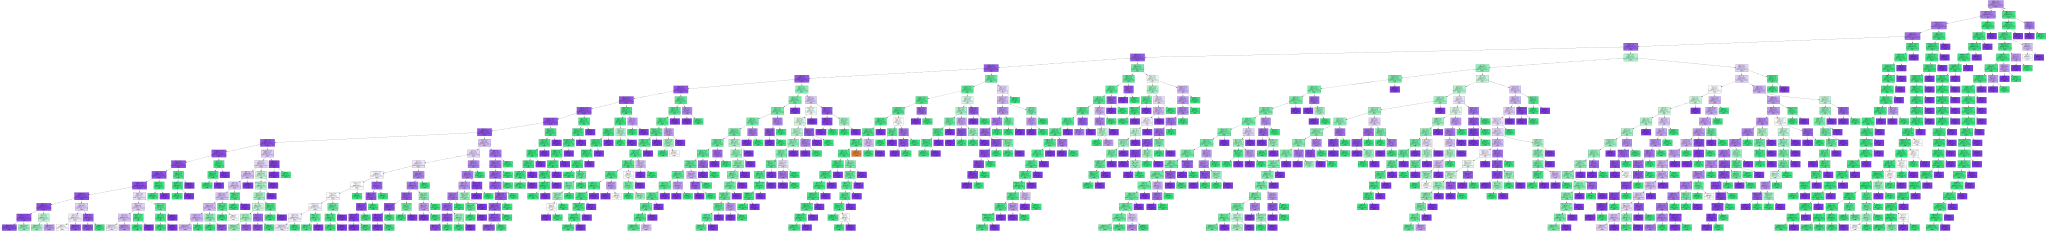

In [ ]:
dt_res[2]

## Ada boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#suprisingly not working
def adaboost(filename, test_size = 0.2, take_spam = False, binary = True):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)

  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  model = AdaBoostClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

ada_res = adaboost("normalized_all.csv", 0.2)
print(ada_res[0])
print(ada_res[1])

              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
     hateful       0.29      0.82      0.43      5167
      normal       0.70      0.17      0.28     12347

    accuracy                           0.36     17515
   macro avg       0.33      0.33      0.24     17515
weighted avg       0.58      0.36      0.32     17515

[[    0     0     1]
 [    0  4259   908]
 [    0 10218  2129]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def gradboost(filename, test_size = 0.2, take_spam = False, binary = True, stemming=False):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)
  if stemming==True:
    snowBallStemmer = SnowballStemmer("english")    
    X_train2 = []
    X_test2 = []
    for sen in X_train:

      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_train2.append(' '.join(stemWords))
    X_train = X_train2
    for sen in X_test:
      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_test2.append(' '.join(stemWords))
    X_test = X_test2

  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  model = GradientBoostingClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

grad_res = gradboost("normalized_all.csv", 0.2, stemming=True)
print(grad_res[0])
print(grad_res[1])

              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
     hateful       0.93      0.71      0.80      5101
      normal       0.89      0.98      0.93     12413

    accuracy                           0.90     17515
   macro avg       0.61      0.56      0.58     17515
weighted avg       0.90      0.90      0.89     17515

[[    0     0     1]
 [    0  3611  1490]
 [    0   284 12129]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
#not working, overfitting
def extra(filename, test_size = 0.2, take_spam = False, binary = True):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)

  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  model = ExtraTreesClassifier(max_depth=15)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

extra_res = extra("normalized_all.csv", 0.2)
print(extra_res[0])
print(extra_res[1])

              precision    recall  f1-score   support

     hateful       1.00      0.00      0.00      5205
      normal       0.70      1.00      0.83     12310

    accuracy                           0.70     17515
   macro avg       0.85      0.50      0.41     17515
weighted avg       0.79      0.70      0.58     17515

[[    4  5201]
 [    0 12310]]


## XGBoost

In [ ]:
from xgboost import XGBClassifier

def xgboost_trained(filename, test_size = 0.2, take_spam = False, binary = True, stemming=False):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)

  if stemming:
    snowBallStemmer = SnowballStemmer("english")

    X_train2 = []
    X_test2 = []
    for sen in X_train:

      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_train2.append(' '.join(stemWords))
    X_train = X_train2
    for sen in X_test:
      wordList = nltk.word_tokenize(sen)
      stemWords = [snowBallStemmer.stem(word) for word in wordList]
      X_test2.append(' '.join(stemWords))
    X_test = X_test2

  vectorizer = CountVectorizer()

  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  model = XGBClassifier(learning_rate=0.3, n_estimators=500, max_depth=4, min_child_weight=1, colsample_bytree=0.8, subsample=0.7)


  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

In [ ]:
xg_res = xgboost_trained("normalized_all.csv", 0.2, stemming=True)
print(xg_res[0])
print(xg_res[1]) 

              precision    recall  f1-score   support

     hateful       0.90      0.76      0.82      5178
      normal       0.90      0.97      0.93     12337

    accuracy                           0.90     17515
   macro avg       0.90      0.86      0.88     17515
weighted avg       0.90      0.90      0.90     17515

[[ 3916  1262]
 [  422 11915]]


In [ ]:
xg_res = xgboost_trained("normalized_all.csv", 0.2, stemming=False)
print(xg_res[0])
print(xg_res[1]) 

              precision    recall  f1-score   support

     hateful       0.91      0.74      0.81      5228
      normal       0.90      0.97      0.93     12287

    accuracy                           0.90     17515
   macro avg       0.90      0.85      0.87     17515
weighted avg       0.90      0.90      0.90     17515

[[ 3854  1374]
 [  382 11905]]


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(filename, test_size = 0.2, take_spam = False, binary = True):
  texts = []
  labels = []
  with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:tfid vec
      if not take_spam and row[1] == 'spam':
        continue
      if binary and row[1] == 'abusive':
        texts.append(row[0])
        labels.append('hateful')
        continue

      texts.append(row[0])
      labels.append(row[1])
                        
  X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)
  print(len(X_train))
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)

  print(X_train.shape)
  X_test = vectorizer.transform(X_test)
  model = RandomForestClassifier(n_estimators=100000, max_depth=15)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

rf_res = random_forest("normalized_all.csv", 0.2)
print(rf_res[0])
print(rf_res[1])

70059
(70059, 46506)
              precision    recall  f1-score   support

     hateful       0.95      0.00      0.01      5106
      normal       0.71      1.00      0.83     12409

    accuracy                           0.71     17515
   macro avg       0.83      0.50      0.42     17515
weighted avg       0.78      0.71      0.59     17515

[[   21  5085]
 [    1 12408]]


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def logistic(filename, test_size = 0.2, vect_method = CountVectorizer, take_spam = False, binary = True, stemming=False):

    texts = []
    labels = []

    with open(filename ,newline='', encoding="UTF-8-SIG") as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      for row in reader:
        if not take_spam and row[1] == 'spam':
          continue
        if binary and row[1] == 'abusive':
          texts.append(row[0])
          labels.append('hateful')
          continue
        texts.append(row[0])
        labels.append(row[1])
                        
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size = test_size)

    if stemming:
      snowBallStemmer = SnowballStemmer("english")

      X_train2 = []
      X_test2 = []
      for sen in X_train:

        wordList = nltk.word_tokenize(sen)
        stemWords = [snowBallStemmer.stem(word) for word in wordList]
        X_train2.append(' '.join(stemWords))
      X_train = X_train2
      for sen in X_test:
        wordList = nltk.word_tokenize(sen)
        stemWords = [snowBallStemmer.stem(word) for word in wordList]
        X_test2.append(' '.join(stemWords))
      X_test = X_test2

    vectorizer = vect_method()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return report, conf_matrix


In [ ]:
lr_res = logistic("normalized_all.csv", 0.2, vect_method = TfidfVectorizer, binary = True, stemming=True)
print(lr_res[0])
print(lr_res[1])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

     hateful       0.91      0.73      0.81      5169
      normal       0.89      0.97      0.93     12346

    accuracy                           0.90     17515
   macro avg       0.90      0.85      0.87     17515
weighted avg       0.90      0.90      0.89     17515

[[ 3762  1407]
 [  393 11953]]
